<a href="https://colab.research.google.com/github/brianross93/epltransferpricepredictor/blob/main/EPLTransferMLPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook conducts a Linear Regression Machine Learning analysis to predict English Premier League player values for the 2019/2020 season. This season is an interesting season to look at as it was during the outbreak of Covid-19, and this had a dramatic affect on the transfer market. This notebook conducts and Linear Regression modeling as well as a K Means clustering of players with a Priciple Component Analysis

If you don't know what any of that means, that's totally cool. Basically this predicts player values and then groups them based on what the Machine Learning model thinks the players have in common. The results are fascinating. 

To perform this analysis, we will be using the Pandas, Seaborn, Matplotlib, Numpy, and various models from SkLearn. 



The first thing we have to do is import our datasets.

In [ ]:
#importing player stats for 2019/2020 English Premier League season. 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


epl_stats = pd.read_csv("epl_players_stats.csv")
epl_stats.head()


,id,name,nationality,team,team_id,age,height,weight,position,roles,games,exit_on_sub,minutes,rating_m,goals,assists,yel_cards,red_cards,shots_m,aerials_won_m,motm,successful_passes_pt,key_passes_m,dribbles_won_m,fouls_given_m,offside_m,dispossessed_m,passes_m,accurate_crosses_m,accurate_long_passes_m,accurate_through_passes_m,tackles_m,interceptions_m,fouls_m,clearances_m,dribbled_past_m,owm_goals,gk_in_goal_area_saves_m,gk_inside_box_saves_m,gk_outside_box_saves_m,gk_saves_m
0,816,Kevin De Bruyne,be,Man City,875,29,181,68,Midfielder,"M_C,M_L,M_R,FW",35,3,2800,7.97,13,20,3,0,2.8,0.5,10,81.5,3.9,1.4,0.8,0.1,0.9,54.5,2.1,3.5,0.4,1.3,0.5,0.7,0.7,1.4,0,0.0,0.0,0.0,0.0
1,622,Bruno Fernandes,pt,Man Utd,314,26,179,69,Midfielder,"M_C,M_L,M_R",14,0,1223,7.73,8,7,2,0,3.1,0.2,3,75.7,2.1,1.1,1.0,0.1,0.9,55.5,1.0,3.3,0.3,1.6,0.8,0.6,1.0,2.4,0,0.0,0.0,0.0,0.0
2,812,Ricardo Pereira,pt,Leicester,652,26,175,70,Defender,"D_L,D_R,M_R",28,0,2520,7.50,3,2,1,0,0.6,1.5,2,78.9,1.0,2.1,1.3,0.0,1.1,56.1,0.3,2.1,0.1,4.2,1.8,1.6,2.6,1.9,0,0.0,0.0,0.0,0.0
3,287,Adama Traoré,es,Wolves,518,24,178,72,Forward,"M_L,M_R,FW",37,10,2608,7.49,4,9,1,0,1.2,1.2,6,74.4,1.3,5.0,2.1,0.2,1.8,19.2,1.2,0.2,0.1,0.9,0.4,1.1,0.4,0.4,0,0.0,0.0,0.0,0.0
4,158,Riyad Mahrez,dz,Man City,875,29,179,67,Forward,"AM_C,AM_L,AM_R",33,12,1942,7.48,11,9,0,0,2.2,0.3,3,90.1,1.8,1.6,0.9,0.4,1.0,33.2,0.6,1.7,0.2,0.8,0.5,0.4,0.2,0.8,0,0.0,0.0,0.0,0.0


In [ ]:
# importing transfer data set for EPL 19/20

epl_transfer = pd.read_csv("/content/english_premier_league.csv")
epl_transfer.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season
0,Arsenal FC,Thomas Partey,27,Defensive Midfield,Atlético Madrid,£45.00m,in,Summer,45.0,Premier League,2020,2020/2021
1,Arsenal FC,Gabriel,22,Centre-Back,LOSC Lille,£23.40m,in,Summer,23.4,Premier League,2020,2020/2021
2,Arsenal FC,Pablo Marí,26,Centre-Back,Flamengo,£3.60m,in,Summer,3.6,Premier League,2020,2020/2021
3,Arsenal FC,Rúnar Alex Rúnarsson,25,Goalkeeper,Dijon,£1.80m,in,Summer,1.8,Premier League,2020,2020/2021
4,Arsenal FC,Cédric Soares,28,Right-Back,Southampton,free transfer,in,Summer,NaN,Premier League,2020,2020/2021


Here we grabbed some datasets we found in the internet. The Player transfer dataset I found in a random github that can be found here: https://github.com/ewenme/transfers It also has a lot of data for different leagues in different leagues, but we were limited by the availability of corresponding statistical data. 

The statsitical data is grabbed from kaggle, and can be seen here: https://www.kaggle.com/cashncarry/epl-players-deep-stats-20192020


Now we're going to combine these datasets on all the players which have had a transfer occur, whether in or out. 

In [ ]:
# Combine the datasets and remove NaN values (mostly from free transfers) 
combine_epl = pd.merge(left=epl_transfer, right=epl_stats, left_on='player_name', right_on='name')
combine_epl.fillna("0")

,club_name,player_name,age_x,position_x,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season,id,name,nationality,team,team_id,age_y,height,weight,position_y,roles,games,exit_on_sub,minutes,rating_m,goals,assists,yel_cards,red_cards,shots_m,aerials_won_m,motm,successful_passes_pt,key_passes_m,dribbles_won_m,fouls_given_m,offside_m,dispossessed_m,passes_m,accurate_crosses_m,accurate_long_passes_m,accurate_through_passes_m,tackles_m,interceptions_m,fouls_m,clearances_m,dribbled_past_m,owm_goals,gk_in_goal_area_saves_m,gk_inside_box_saves_m,gk_outside_box_saves_m,gk_saves_m
0,Arsenal FC,Pablo Marí,26,Centre-Back,Flamengo,£3.60m,in,Summer,3.6,Premier League,2020,2020/2021,449,Pablo Marí,es,Arsenal,924,27,193,87,Defender,D_C,2,0,114,6.94,0,0,0,0,0.0,2.0,0,85.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,4.0,0.0,1.0,0.5,1.0,4.5,0.0,0,0.0,0.0,0.0,0.0
1,Arsenal FC,Pablo Marí,26,Centre-Back,Flamengo,"End of loanJun 30, 2020",out,Summer,0,Premier League,2020,2020/2021,449,Pablo Marí,es,Arsenal,924,27,193,87,Defender,D_C,2,0,114,6.94,0,0,0,0,0.0,2.0,0,85.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,4.0,0.0,1.0,0.5,1.0,4.5,0.0,0,0.0,0.0,0.0,0.0
2,Arsenal FC,Cédric Soares,28,Right-Back,Southampton,free transfer,in,Summer,0,Premier League,2020,2020/2021,358,Cédric Soares,pt,Southampton,959,29,172,67,Defender,"D_R,M_R",16,0,1310,6.76,0,1,1,0,0.6,1.1,1,68.8,0.7,0.2,0.2,0.0,0.6,30.9,0.9,1.4,0.0,2.8,1.2,0.6,2.8,1.0,0,0.0,0.0,0.0,0.0
3,Arsenal FC,Cédric Soares,28,Right-Back,Southampton,free transfer,in,Summer,0,Premier League,2020,2020/2021,358,Cédric Soares,pt,Arsenal,924,29,172,67,Defender,"D_R,M_R",5,2,250,6.62,1,0,0,0,0.2,0.4,0,79.8,0.2,0.4,0.2,0.0,0.2,19.8,0.2,1.2,0.0,1.6,0.6,1.2,0.2,0.4,0,0.0,0.0,0.0,0.0
4,Arsenal FC,Cédric Soares,28,Right-Back,Southampton,"End of loanJun 30, 2020",out,Summer,0,Premier League,2020,2020/2021,358,Cédric Soares,pt,Southampton,959,29,172,67,Defender,"D_R,M_R",16,0,1310,6.76,0,1,1,0,0.6,1.1,1,68.8,0.7,0.2,0.2,0.0,0.6,30.9,0.9,1.4,0.0,2.8,1.2,0.6,2.8,1.0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,West Bromwich Albion,Robert Snodgrass,33,Right Winger,West Ham,£99Th.,in,Winter,0.099,Premier League,2020,2020/2021,128,Robert Snodgrass,gb-sct,West Ham,928,33,182,82,Midfielder,"AM_C,AM_L,AM_R",24,7,1513,6.79,5,5,4,0,0.9,0.6,1,77.8,1.4,0.8,1.3,0.2,1.0,21.0,1.6,0.7,0.0,1.2,0.2,0.8,0.5,1.3,0,0.0,0.0,0.0,0.0
204,West Ham United,Robert Snodgrass,33,Right Winger,West Brom,£99Th.,out,Winter,0.099,Premier League,2020,2020/2021,128,Robert Snodgrass,gb-sct,West Ham,928,33,182,82,Midfielder,"AM_C,AM_L,AM_R",24,7,1513,6.79,5,5,4,0,0.9,0.6,1,77.8,1.4,0.8,1.3,0.2,1.0,21.0,1.6,0.7,0.0,1.2,0.2,0.8,0.5,1.3,0,0.0,0.0,0.0,0.0
205,West Ham United,Sébastien Haller,26,Centre-Forward,Ajax,£20.25m,out,Winter,20.25,Premier League,2020,2020/2021,564,Sébastien Haller,fr,West Ham,928,26,190,82,Forward,FW,32,8,2263,7.08,7,1,1,0,1.8,6.8,3,65.8,0.8,0.8,1.2,0.6,1.1,24.0,0.0,0.4,0.0,0.7,0.2,1.4,0.8,0.8,0,0.0,0.0,0.0,0.0
206,Wolverhampton Wanderers,Patrick Cutrone,23,Centre-Forward,Fiorentina,"End of loanJan 7, 2021",in,Winter,0,Premier League,2020,2020/2021,922,Patrick Cutrone,it,Wolves,518,22,183,75,Forward,FW,12,9,295,6.31,2,0,0,0,0.9,0.7,0,69.5,0.2,0.2,0.8,0.3,0.8,4.9,0.1,0.0,0.0,0.3,0.2,0.4,0.1,0.3,0,0.0,0.0,0.0,0.0


Just for fun, lets look at the average values of each of the columns. This will give us a reference point for players to see if they're above or below average anywhere. I won't be doing that type of analysis, but it will be interesting to match this up with the PCA categorization which happens later. 

In [ ]:
#explore the data and seeing averages for each column

combine_epl.mean()



age_x                          26.596154
fee_cleaned                     4.928369
year                         2020.000000
id                            536.341346
team_id                       625.653846
age_y                          26.504808
height                        174.355769
weight                         71.038462
games                          14.557692
exit_on_sub                     4.812500
minutes                       882.173077
rating_m                        6.481298
goals                           0.985577
assists                         0.855769
yel_cards                       1.471154
red_cards                       0.038462
shots_m                         0.591827
aerials_won_m                   0.952885
motm                            0.418269
successful_passes_pt           77.515385
key_passes_m                    0.453846
dribbles_won_m                  0.547115
fouls_given_m                   0.592308
offside_m                       0.085577
dispossessed_m  

In [ ]:
#Returning max transfer value in Euros

combine_epl["fee_cleaned"].max()

45.18

Next we make a heatmap. We can see from this heatmap that height and weight have a strong correlation, which is expected, as well as the goalie stats. We will drop most the goalie stats, both height and weight (thats a judgement call, I'm not convinced height gives any useful data if you have data on headers won), and we can also drop some of the passing columns. 

We will keep key passes, and get rid of accurate crosses because an accurate cross would in most cases be considered a key pass. 

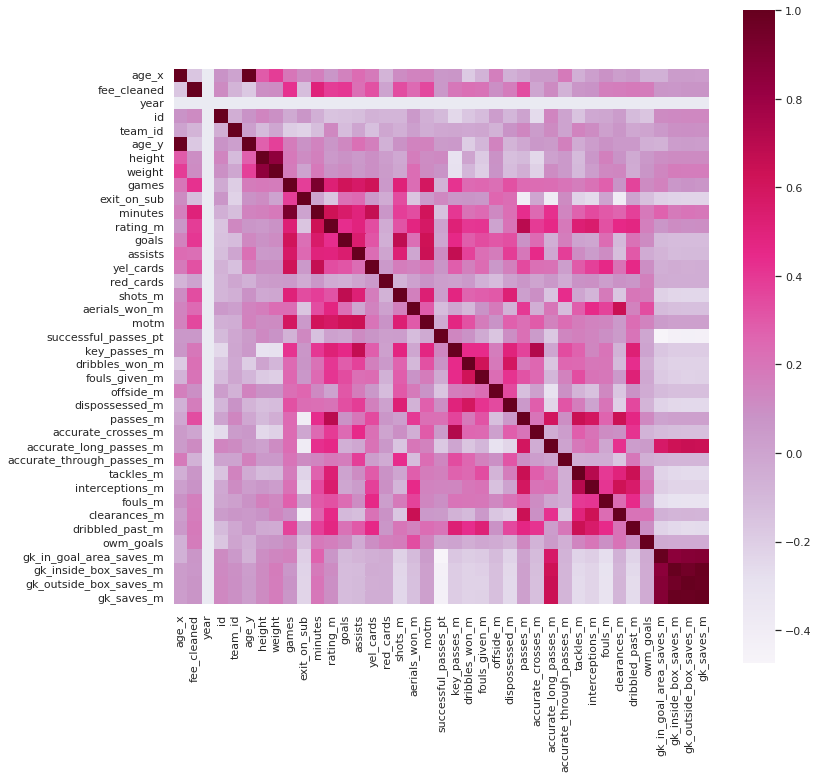

In [ ]:
#Correlation Heatmap says height and weight are correlated, as well as all the goalie stats
sns.set(rc={'figure.figsize':(12,12)})
sns.heatmap(combine_epl.corr(), cmap="PuRd", square=True)

In [ ]:
#Cleaning dataset 
#Removing Accurate Crosses because of the correlation with Key Passes Made
#Removing Height and Weight because they aren't as relevant as the other stats. It doesn't matter 
# How tall you are if you win every header.
#Also removed a lot of Goalkeeper values
feature_cols = ['team_id', 'age_y', "games", "minutes", "rating_m", 
                "goals", "assists", "yel_cards", "red_cards", "shots_m", "aerials_won_m", "motm", "successful_passes_pt", "key_passes_m",
                "dribbles_won_m", "fouls_given_m", "offside_m", "dispossessed_m", "passes_m", "accurate_long_passes_m",
                "accurate_through_passes_m", "tackles_m", "interceptions_m", "fouls_m", "clearances_m", "dribbled_past_m",
                "gk_saves_m"]

X = combine_epl[feature_cols]
y = combine_epl['fee_cleaned'].fillna(0)
#Look at our beautiful data
print(X)
print(y)

     team_id  age_y  games  ...  clearances_m  dribbled_past_m  gk_saves_m
0        924     27      2  ...           4.5              0.0         0.0
1        924     27      2  ...           4.5              0.0         0.0
2        959     29     16  ...           2.8              1.0         0.0
3        924     29      5  ...           0.2              0.4         0.0
4        959     29     16  ...           2.8              1.0         0.0
..       ...    ...    ...  ...           ...              ...         ...
203      928     33     24  ...           0.5              1.3         0.0
204      928     33     24  ...           0.5              1.3         0.0
205      928     26     32  ...           0.8              0.8         0.0
206      518     22     12  ...           0.1              0.3         0.0
207      518     22     12  ...           0.1              0.3         0.0

[208 rows x 27 columns]
0       3.600
1       0.000
2       0.000
3       0.000
4       0.000
     

Now lets make sure our data shapes are the same. The model will yell at us if they aren't. 

Also I forgot to mention we have to be careful to replace NaN values for transfers. We replace those NaN's with zero because a NaN transfer is normally a free transfer which has no fee associated with it. 

In [ ]:
X.shape

(208, 27)

In [ ]:
y.shape

(208,)

Swag. They're the same shape. 

Here's a Scatter plot. This scatter plot allows us to visualize the spread of data. We can see the amount of transfers conducted by each team, and the value of those transfers. It does not differentiate between transfers in and out at this point, but I would imagine these values are much lower than average because of the impact Covid had on tream finances. 

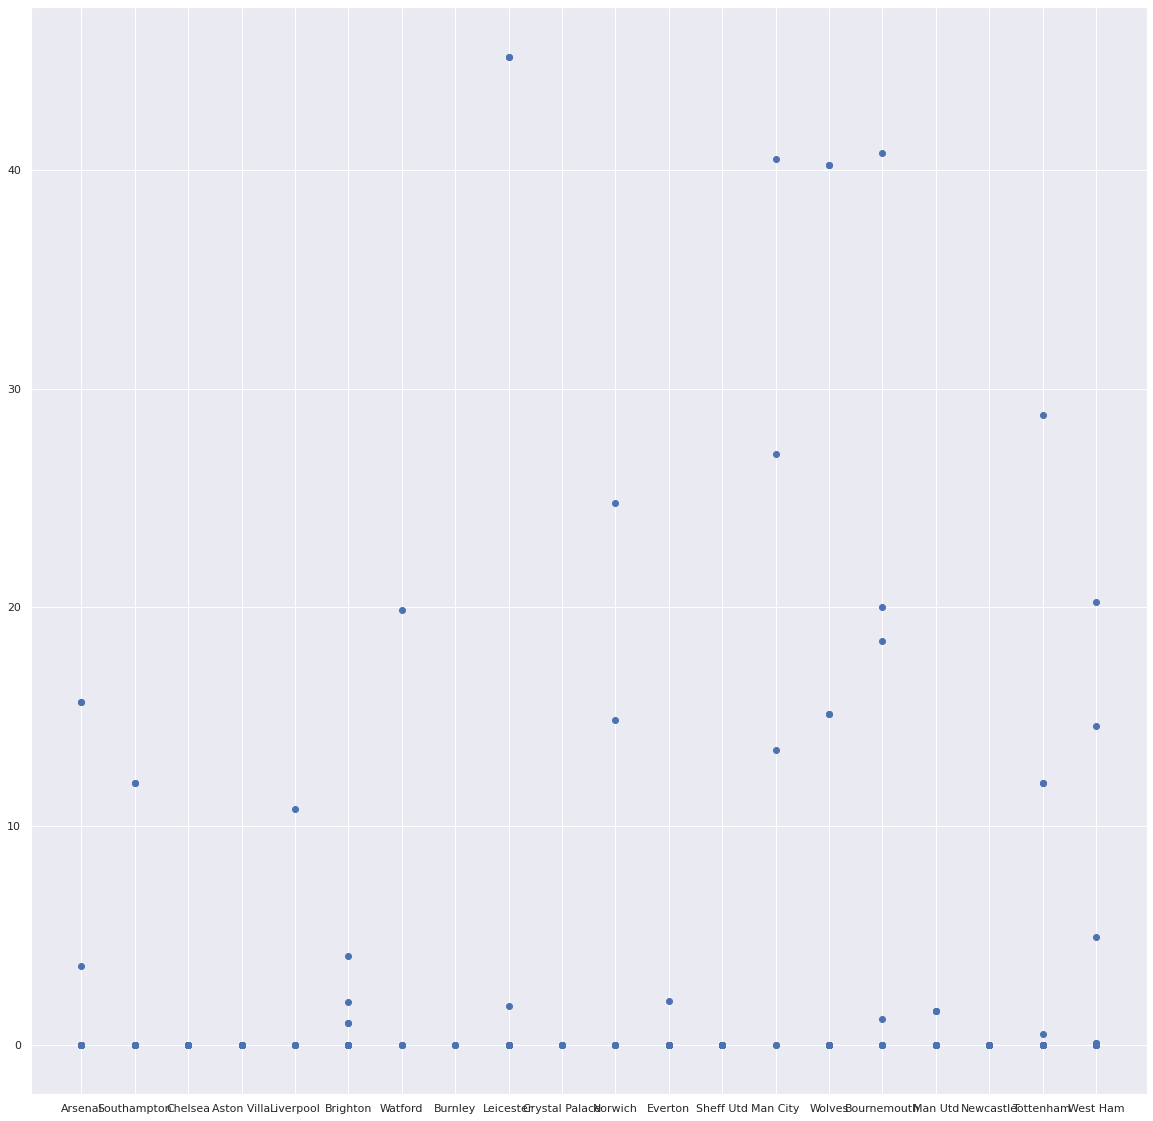

In [ ]:
plt.figure(figsize=(20,20))
plt.scatter(combine_epl["team"], y, )

Now we're going to process the data and import it into our Machine Learning model.

We will be using a Linear Regression model and also calculating the r-squared to see how close our model gets. 

In [ ]:
# Lets start preprocessing the data
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score




X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

EplReg = LinearRegression()
EplReg.fit(X, y)

y_pred = EplReg.predict(X_test)

# print intercept and coefficients
print(EplReg.intercept_)
print(EplReg.coef_)

print(EplReg.predict(X_test))


# # create a fitted model with all three features
#to_square = smf.ols(formula='combine_epl ~ team_id + age_y', data=combine_epl).fit()

rsquared = r2_score(y_test, y_pred)
print(f"the R squared is { rsquared }")

-34.90703451162747
[ 8.78675302e-04 -2.56385040e-01 -3.69424903e-01  1.04746725e-02
  5.57146928e+00  3.71675014e-03 -1.36739927e+00 -3.34989612e-01
  9.49122809e-01  3.65348261e+00 -6.54969751e-01  5.91408803e-01
  8.67291913e-02 -4.42454368e+00 -1.74112977e-01  1.27570129e-02
 -2.67957764e+00 -7.27947747e-01  2.93996398e-01 -3.63837911e+00
 -2.58996626e+01 -3.41586730e+00 -5.02652371e+00  7.58432266e-01
  2.13226041e-01  4.68073112e+00  2.32511487e+00]
[  8.87329255  -0.30652967   8.7882713   -1.78098345   7.74751249
  22.45998389   4.92702771  -2.04604032  15.46553124  14.93161309
  16.78345277   1.66440532  -1.59846603   5.3534311   10.96224725
   8.22063286   2.07574152  -2.29495636  -0.25388946   0.11220061
  -0.77929965  10.9256333   -1.78098345   1.12328233  -1.36265387
   7.95845466   2.42146849   2.42146849  -5.4547637   -1.84447626
   1.5410756   -1.27131806   7.95845466  11.14330189   0.67367555
  -2.20766753   5.88991267   4.92702771  10.9256333    6.38572552
   1.1609343 

Now we can make a set of predictions on the data. This is what that looks like in raw numerical form, but we can manually look at some players too and see what it says. But before we do, how about a scatter of our predicted values and actual values, see how close we are. 

In [ ]:
print("Predictions")
print(EplReg.predict(X_test))

print("Actual targets")
print(y_test.values)

Predictions
[  8.87329255  -0.30652967   8.7882713   -1.78098345   7.74751249
  22.45998389   4.92702771  -2.04604032  15.46553124  14.93161309
  16.78345277   1.66440532  -1.59846603   5.3534311   10.96224725
   8.22063286   2.07574152  -2.29495636  -0.25388946   0.11220061
  -0.77929965  10.9256333   -1.78098345   1.12328233  -1.36265387
   7.95845466   2.42146849   2.42146849  -5.4547637   -1.84447626
   1.5410756   -1.27131806   7.95845466  11.14330189   0.67367555
  -2.20766753   5.88991267   4.92702771  10.9256333    6.38572552
   1.1609343    2.35793038   1.3479043    1.50241404   0.86331898
   1.5410756    7.95845466  16.78345277  -2.88075632  15.76664346
 -10.56191098   7.81794      1.36360962   6.33660921   0.86331898
  -0.35184216  12.64280196   2.42146849  -2.44481019   3.92636642
  -2.4418558   -1.1458355   -2.27538837]
Actual targets
[ 0.     0.     4.05   0.     0.    40.23   0.     0.    40.77  15.12
 45.18   0.     0.     0.    40.5    0.     0.099  0.     0.     0.
  

Here, we see a grouping around 0. 0 is good, it means we're accurate. There are some outliers which means our model isn't perfect, but on average it gets pretty close. Check out the mean squared error. 

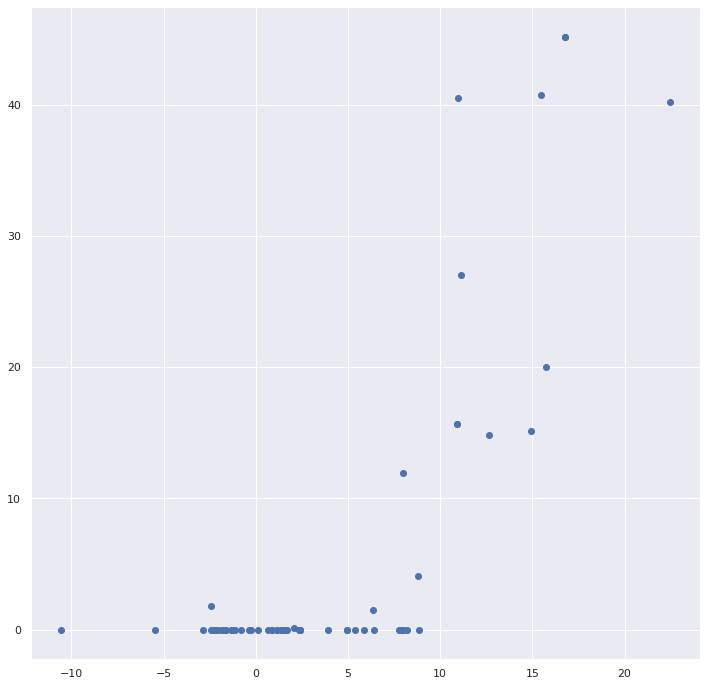

In [ ]:
#Lets make some sense of this data 
plt.scatter(EplReg.predict(X_test), y_test.values )

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

meansquared = mean_squared_error(y_test, y_pred)


print(f"Our mean squared error is {meansquared}")

Our mean squared error is 73.66117925906768


This is a cell for Emile Smith Rowe. We can see the predicted value for ESR was 8.87 million Euros. This passes the smell test, as ESR wasn't a breakout player, but was still seen as a bright prospect. It wasn't until that season and the following season that he broke out to being a mainstay in the team. 

In [ ]:
#Emile Smith Rowe
print(X_test.iloc[0])
print(EplReg.predict(X_test.iloc[0].to_numpy().reshape(1,-1)))

team_id                      924.0
age_y                         20.0
games                          2.0
minutes                       97.0
rating_m                       6.3
goals                          0.0
assists                        0.0
yel_cards                      0.0
red_cards                      0.0
shots_m                        0.0
aerials_won_m                  0.0
motm                           0.0
successful_passes_pt          85.7
key_passes_m                   0.0
dribbles_won_m                 1.0
fouls_given_m                  0.5
offside_m                      0.0
dispossessed_m                 0.5
passes_m                      17.5
accurate_long_passes_m         0.0
accurate_through_passes_m      0.0
tackles_m                      0.5
interceptions_m                0.5
fouls_m                        0.0
clearances_m                   1.0
dribbled_past_m                1.0
gk_saves_m                     0.0
Name: 12, dtype: float64
[8.87329255]


The next prediction is for Joshue King, a striker at Bournemouth. Bournemouth ended up getting relegated, but Joshue King was still seen as a decent player. Joshua King ended up leaving to Everton for a fee of 5 million, which is close to our prediction. The reason for the lower value would be that Bournemouth got relegated, and thus all player values decrease as the team has little leverage to keep the players. 


In [ ]:
#Joshua King
print(X_test.iloc[4])
print(EplReg.predict(X_test.iloc[4].to_numpy().reshape(1,-1)))

team_id                       235.00
age_y                          28.00
games                          26.00
minutes                      2020.00
rating_m                        6.76
goals                           6.00
assists                         4.00
yel_cards                       0.00
red_cards                       0.00
shots_m                         1.00
aerials_won_m                   2.30
motm                            1.00
successful_passes_pt           72.30
key_passes_m                    1.20
dribbles_won_m                  2.00
fouls_given_m                   1.00
offside_m                       0.30
dispossessed_m                  2.10
passes_m                       19.20
accurate_long_passes_m          0.20
accurate_through_passes_m       0.00
tackles_m                       0.60
interceptions_m                 0.30
fouls_m                         1.40
clearances_m                    0.30
dribbled_past_m                 0.50
gk_saves_m                      0.00
N

Lets do 1 more because I'm having fun. Let's predict a high profile player on a big team. I found Rodri from Manchester City in the dataset, lets predict him. 

We can see his value for this season was about 11.1 million Euros. This number is very low. Manchester City bought him for 68 million dollars which is about 58 million Euros. Directionally, however, it is correct in assesing Rodri as higher than the other players. Interesting. 

In [ ]:
from pprint import pprint as pp

print(X_test.iloc[33])
print(EplReg.predict(X_test.iloc[33].to_numpy().reshape(1,-1)))

team_id                       875.00
age_y                          24.00
games                          35.00
minutes                      2488.00
rating_m                        7.09
goals                           3.00
assists                         2.00
yel_cards                       8.00
red_cards                       0.00
shots_m                         0.70
aerials_won_m                   1.60
motm                            1.00
successful_passes_pt           92.90
key_passes_m                    1.00
dribbles_won_m                  0.90
fouls_given_m                   0.90
offside_m                       0.00
dispossessed_m                  0.80
passes_m                       73.70
accurate_long_passes_m          4.90
accurate_through_passes_m       0.10
tackles_m                       1.40
interceptions_m                 0.70
fouls_m                         1.20
clearances_m                    0.90
dribbled_past_m                 1.10
gk_saves_m                      0.00
N

# Now we're going to perform a K Means clustering on the dataset to see what clusters the Machine Learning can find. 

In [ ]:
15# Performing K Means Clustering on Dataset
#Scaling the data

from sklearn import preprocessing

epl_df = preprocessing.scale(X)
epl_y = preprocessing.scale(y)
epl_df


array([[ 1.11325282,  0.11546048, -1.22122653, ...,  3.01027582,
        -1.29479855, -0.22147418],
       [ 1.11325282,  0.11546048, -1.22122653, ...,  3.01027582,
        -1.29479855, -0.22147418],
       [ 1.24385228,  0.58178629,  0.14026338, ...,  1.5469358 ,
         1.10982733, -0.22147418],
       ...,
       [ 1.12817847, -0.11770243,  1.69625186, ..., -0.17464069,
         0.62890215, -0.22147418],
       [-0.401701  , -1.05035405, -0.24873373, ..., -0.77719247,
        -0.57341079, -0.22147418],
       [-0.401701  , -1.05035405, -0.24873373, ..., -0.77719247,
        -0.57341079, -0.22147418]])

Here we perform an Elbow Method Analysis to select the optimal number of clusters. This is important for implementing our K Means model. 

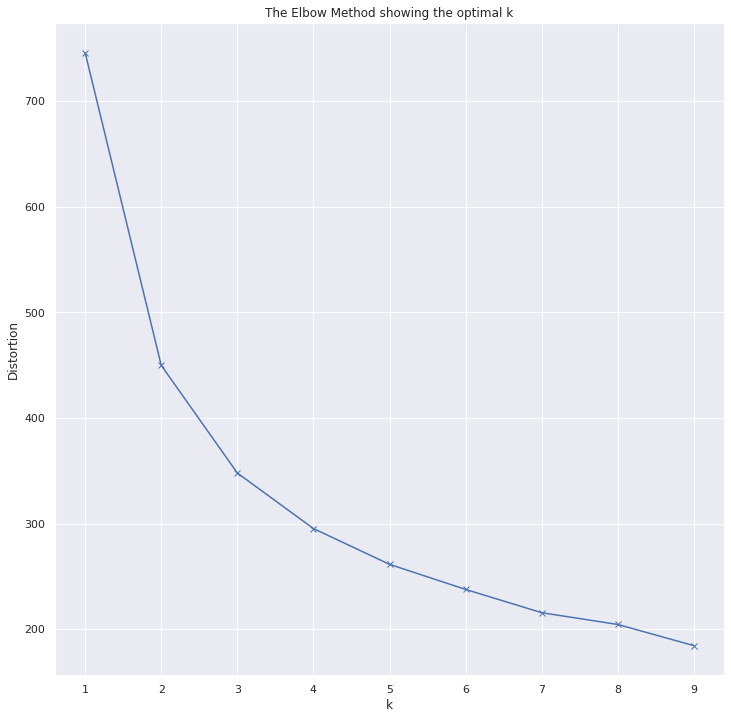

In [ ]:
# Elbow Method to show optimal K
#Doing elbow analysis to find the correct number of clusters.
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

distortions = []
K = range(1, 10)
for k in K:
    # fit the k-means for a given k to the data (X)
    km = KMeans(n_clusters=k)
    km.fit(X)
    # distance.cdist finds the squared distances
    # axis=1 allows us to keep the min for each sample, not just the min across the entire dataset
    # find the closest distance for each sample to a center, and take the average
    distortions.append(sum(np.min(distance.cdist(X, km.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow: bx- = use a solid (-) blue (b) line, 
# and mark the x-axis points with an x (x)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The Elbow Method has spoken. Looks like it sees two clusters as that is the most dramatic uptick. We'll use two clusters for our K Means Clustering. This clustering uses the K Means algorithm to create classifications. 

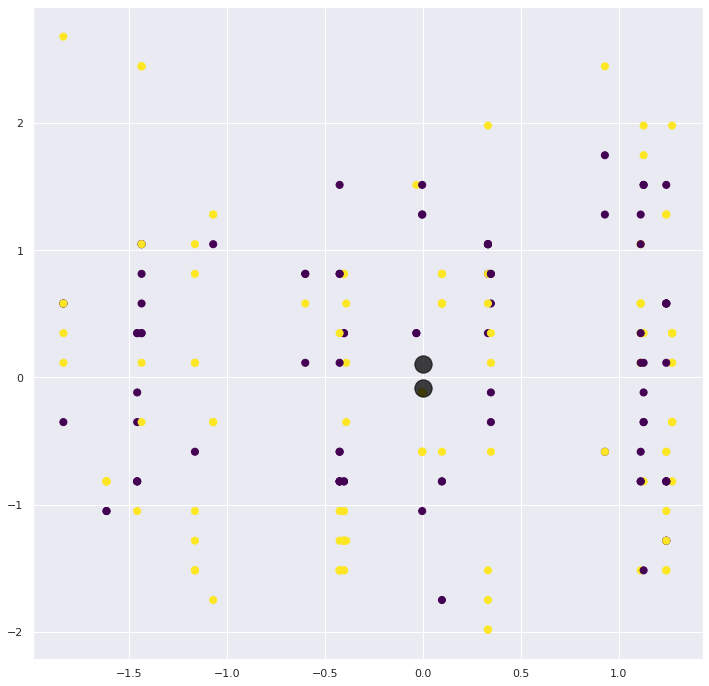

In [ ]:
# Looks like Two clusters to me. This is surprising. 

km = KMeans(n_clusters=2)

# Fit the k-means object to the data
km.fit(epl_df)
y_kmeans = km.predict(epl_df)


# Visualize the data and the clustering
plt.scatter(epl_df[:, 0], epl_df[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, alpha=0.75)

## This map doesn't make too much sense, but since we have two components, I wonder if we can do a Principle Component Analysis on it and see if that gives us a clearer picture. 

---



In [ ]:
#Doing some PCA 
#importing Libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Fitting object with 2 because of results from Elbow Method
pca = PCA(2)
pca.fit(epl_df)

X_with_pca = pca.transform(epl_df)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[7.26146979 3.88933127]
[0.26765033 0.14335676]
[0.26765033 0.41100709]


Looks about right to me. We're printing out the explained varience, the ratio for explained variance, and the cumulutative sum. 

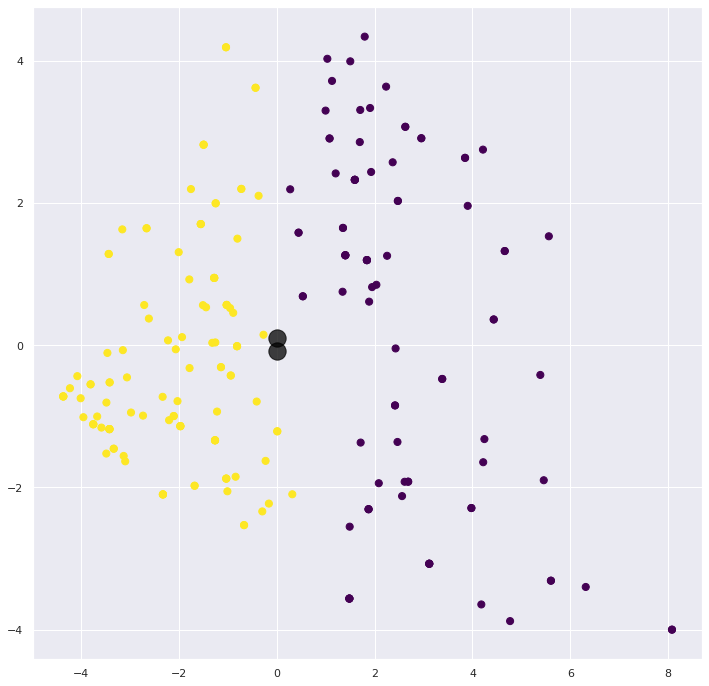

In [ ]:
# Looks good, lets plot it

plt.scatter(X_with_pca[:, 0], X_with_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, alpha=0.75)

But who are in these clusters? That's the big question. It's a nice clear clustering into two categories, but can we make a guess as to what it's clustering by? 

In [ ]:

combine_epl[km.labels_==0]

,club_name,player_name,age_x,position_x,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season,id,name,nationality,team,team_id,age_y,height,weight,position_y,roles,games,exit_on_sub,minutes,rating_m,goals,assists,yel_cards,red_cards,shots_m,aerials_won_m,motm,successful_passes_pt,key_passes_m,dribbles_won_m,fouls_given_m,offside_m,dispossessed_m,passes_m,accurate_crosses_m,accurate_long_passes_m,accurate_through_passes_m,tackles_m,interceptions_m,fouls_m,clearances_m,dribbled_past_m,owm_goals,gk_in_goal_area_saves_m,gk_inside_box_saves_m,gk_outside_box_saves_m,gk_saves_m
2,Arsenal FC,Cédric Soares,28,Right-Back,Southampton,free transfer,in,Summer,NaN,Premier League,2020,2020/2021,358,Cédric Soares,pt,Southampton,959,29,172,67,Defender,"D_R,M_R",16,0,1310,6.76,0,1,1,0,0.6,1.1,1,68.8,0.7,0.2,0.2,0.0,0.6,30.9,0.9,1.4,0.0,2.8,1.2,0.6,2.8,1.0,0,0.0,0.0,0.0,0.0
4,Arsenal FC,Cédric Soares,28,Right-Back,Southampton,"End of loanJun 30, 2020",out,Summer,0.000,Premier League,2020,2020/2021,358,Cédric Soares,pt,Southampton,959,29,172,67,Defender,"D_R,M_R",16,0,1310,6.76,0,1,1,0,0.6,1.1,1,68.8,0.7,0.2,0.2,0.0,0.6,30.9,0.9,1.4,0.0,2.8,1.2,0.6,2.8,1.0,0,0.0,0.0,0.0,0.0
6,Southampton FC,Cédric Soares,28,Right-Back,Arsenal,"End of loanJun 30, 2020",in,Summer,0.000,Premier League,2020,2020/2021,358,Cédric Soares,pt,Southampton,959,29,172,67,Defender,"D_R,M_R",16,0,1310,6.76,0,1,1,0,0.6,1.1,1,68.8,0.7,0.2,0.2,0.0,0.6,30.9,0.9,1.4,0.0,2.8,1.2,0.6,2.8,1.0,0,0.0,0.0,0.0,0.0
8,Southampton FC,Cédric Soares,28,Right-Back,Arsenal,free transfer,out,Summer,NaN,Premier League,2020,2020/2021,358,Cédric Soares,pt,Southampton,959,29,172,67,Defender,"D_R,M_R",16,0,1310,6.76,0,1,1,0,0.6,1.1,1,68.8,0.7,0.2,0.2,0.0,0.6,30.9,0.9,1.4,0.0,2.8,1.2,0.6,2.8,1.0,0,0.0,0.0,0.0,0.0
10,Arsenal FC,Willian,32,Right Winger,Chelsea,free transfer,in,Summer,NaN,Premier League,2020,2020/2021,162,Willian,br,Chelsea,625,32,175,77,Forward,"AM_C,AM_L,AM_R",36,7,2605,7.31,9,7,4,0,2.0,0.3,4,82.7,2.1,1.8,1.2,0.1,0.8,39.9,1.4,1.8,0.1,1.2,0.6,0.5,0.2,0.8,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Liverpool FC,Ben Davies,25,Centre-Back,Preston,£513Th.,in,Winter,0.513,Premier League,2020,2020/2021,607,Ben Davies,gb-wls,Tottenham,512,27,181,76,Defender,"D_C,D_L,M_L",18,2,1432,6.77,0,0,6,0,0.4,2.5,1,76.6,0.5,0.5,0.4,0.1,0.5,44.2,0.6,1.4,0.0,1.6,1.2,1.5,2.3,0.8,0,0.0,0.0,0.0,0.0
200,Southampton FC,Shane Long,34,Centre-Forward,Bournemouth,loan transfer,out,Winter,NaN,Premier League,2020,2020/2021,624,Shane Long,ie,Southampton,959,33,178,81,Forward,"AM_R,FW",26,11,1399,6.67,2,2,0,0,1.3,4.3,0,54.1,0.8,0.2,1.0,0.5,0.8,14.7,0.1,0.1,0.0,0.7,0.2,1.2,0.6,0.5,0,0.0,0.0,0.0,0.0
203,West Bromwich Albion,Robert Snodgrass,33,Right Winger,West Ham,£99Th.,in,Winter,0.099,Premier League,2020,2020/2021,128,Robert Snodgrass,gb-sct,West Ham,928,33,182,82,Midfielder,"AM_C,AM_L,AM_R",24,7,1513,6.79,5,5,4,0,0.9,0.6,1,77.8,1.4,0.8,1.3,0.2,1.0,21.0,1.6,0.7,0.0,1.2,0.2,0.8,0.5,1.3,0,0.0,0.0,0.0,0.0
204,West Ham United,Robert Snodgrass,33,Right Winger,West Brom,£99Th.,out,Winter,0.099,Premier League,2020,2020/2021,128,Robert Snodgrass,gb-sct,West Ham,928,33,182,82,Midfielder,"AM_C,AM_L,AM_R",24,7,1513,6.79,5,5,4,0,0.9,0.6,1,77.8,1.4,0.8,1.3,0.2,1.0,21.0,1.6,0.7,0.0,1.2,0.2,0.8,0.5,1.3,0,0.0,0.0,0.0,0.0


In [ ]:
combine_epl[km.labels_==1]

,club_name,player_name,age_x,position_x,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season,id,name,nationality,team,team_id,age_y,height,weight,position_y,roles,games,exit_on_sub,minutes,rating_m,goals,assists,yel_cards,red_cards,shots_m,aerials_won_m,motm,successful_passes_pt,key_passes_m,dribbles_won_m,fouls_given_m,offside_m,dispossessed_m,passes_m,accurate_crosses_m,accurate_long_passes_m,accurate_through_passes_m,tackles_m,interceptions_m,fouls_m,clearances_m,dribbled_past_m,owm_goals,gk_in_goal_area_saves_m,gk_inside_box_saves_m,gk_outside_box_saves_m,gk_saves_m
0,Arsenal FC,Pablo Marí,26,Centre-Back,Flamengo,£3.60m,in,Summer,3.6,Premier League,2020,2020/2021,449,Pablo Marí,es,Arsenal,924,27,193,87,Defender,D_C,2,0,114,6.94,0,0,0,0,0.0,2.0,0,85.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,4.0,0.0,1.0,0.5,1.0,4.5,0.0,0,0.00,0.0,0.0,0.0
1,Arsenal FC,Pablo Marí,26,Centre-Back,Flamengo,"End of loanJun 30, 2020",out,Summer,0.0,Premier League,2020,2020/2021,449,Pablo Marí,es,Arsenal,924,27,193,87,Defender,D_C,2,0,114,6.94,0,0,0,0,0.0,2.0,0,85.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,4.0,0.0,1.0,0.5,1.0,4.5,0.0,0,0.00,0.0,0.0,0.0
3,Arsenal FC,Cédric Soares,28,Right-Back,Southampton,free transfer,in,Summer,NaN,Premier League,2020,2020/2021,358,Cédric Soares,pt,Arsenal,924,29,172,67,Defender,"D_R,M_R",5,2,250,6.62,1,0,0,0,0.2,0.4,0,79.8,0.2,0.4,0.2,0.0,0.2,19.8,0.2,1.2,0.0,1.6,0.6,1.2,0.2,0.4,0,0.00,0.0,0.0,0.0
5,Arsenal FC,Cédric Soares,28,Right-Back,Southampton,"End of loanJun 30, 2020",out,Summer,0.0,Premier League,2020,2020/2021,358,Cédric Soares,pt,Arsenal,924,29,172,67,Defender,"D_R,M_R",5,2,250,6.62,1,0,0,0,0.2,0.4,0,79.8,0.2,0.4,0.2,0.0,0.2,19.8,0.2,1.2,0.0,1.6,0.6,1.2,0.2,0.4,0,0.00,0.0,0.0,0.0
7,Southampton FC,Cédric Soares,28,Right-Back,Arsenal,"End of loanJun 30, 2020",in,Summer,0.0,Premier League,2020,2020/2021,358,Cédric Soares,pt,Arsenal,924,29,172,67,Defender,"D_R,M_R",5,2,250,6.62,1,0,0,0,0.2,0.4,0,79.8,0.2,0.4,0.2,0.0,0.2,19.8,0.2,1.2,0.0,1.6,0.6,1.2,0.2,0.4,0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,Newcastle United,DeAndre Yedlin,27,Right-Back,Galatasaray,free transfer,out,Winter,NaN,Premier League,2020,2020/2021,144,DeAndre Yedlin,us,Newcastle,719,27,172,75,Defender,"D_R,M_R",16,6,937,6.33,1,0,3,0,0.1,0.5,0,74.4,0.4,0.1,0.6,0.1,0.3,15.4,0.4,0.8,0.0,1.1,0.6,0.5,1.0,0.5,0,0.00,0.0,0.0,0.0
201,Tottenham Hotspur,Paulo Gazzaniga,29,Goalkeeper,Elche CF,loan transfer,out,Winter,NaN,Premier League,2020,2020/2021,352,Paulo Gazzaniga,ar,Tottenham,512,28,196,90,Goalkeeper,GK,18,1,1612,6.65,0,0,1,0,0.0,0.3,1,59.4,0.1,0.0,0.1,0.0,0.0,25.3,0.0,4.2,0.0,0.0,0.1,0.1,0.4,0.0,0,0.17,1.8,1.2,3.2
202,Tottenham Hotspur,Gedson Fernandes,22,Central Midfield,Benfica,"End of loanJan 31, 2021",out,Winter,0.0,Premier League,2020,2020/2021,361,Gedson Fernandes,pt,Tottenham,512,21,182,71,Midfielder,"AM_C,AM_R",7,7,63,6.12,0,0,0,0,0.1,0.0,0,84.6,0.3,0.3,0.3,0.0,0.0,5.6,0.3,0.0,0.0,0.3,0.1,0.0,0.0,0.3,0,0.00,0.0,0.0,0.0
206,Wolverhampton Wanderers,Patrick Cutrone,23,Centre-Forward,Fiorentina,"End of loanJan 7, 2021",in,Winter,0.0,Premier League,2020,2020/2021,922,Patrick Cutrone,it,Wolves,518,22,183,75,Forward,FW,12,9,295,6.31,2,0,0,0,0.9,0.7,0,69.5,0.2,0.2,0.8,0.3,0.8,4.9,0.1,0.0,0.0,0.3,0.2,0.4,0.1,0.3,0,0.00,0.0,0.0,0.0


In [ ]:
#First categorization of incoming transfers
transfer_in = combine_epl[km.labels_==0]
transfer_print = transfer_in[transfer_in["transfer_movement"] == "in"]
transfer_print

# transfer_in = combine_epl[combine_epl["transfer_movement"] == "in"]
# transfer_in[km.labels_==0]

,club_name,player_name,age_x,position_x,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season,id,name,nationality,team,team_id,age_y,height,weight,position_y,roles,games,exit_on_sub,minutes,rating_m,goals,assists,yel_cards,red_cards,shots_m,aerials_won_m,motm,successful_passes_pt,key_passes_m,dribbles_won_m,fouls_given_m,offside_m,dispossessed_m,passes_m,accurate_crosses_m,accurate_long_passes_m,accurate_through_passes_m,tackles_m,interceptions_m,fouls_m,clearances_m,dribbled_past_m,owm_goals,gk_in_goal_area_saves_m,gk_inside_box_saves_m,gk_outside_box_saves_m,gk_saves_m
2,Arsenal FC,Cédric Soares,28,Right-Back,Southampton,free transfer,in,Summer,NaN,Premier League,2020,2020/2021,358,Cédric Soares,pt,Southampton,959,29,172,67,Defender,"D_R,M_R",16,0,1310,6.76,0,1,1,0,0.6,1.1,1,68.8,0.7,0.2,0.2,0.0,0.6,30.9,0.9,1.4,0.0,2.8,1.2,0.6,2.8,1.0,0,0.0,0.0,0.0,0.0
6,Southampton FC,Cédric Soares,28,Right-Back,Arsenal,"End of loanJun 30, 2020",in,Summer,0.000,Premier League,2020,2020/2021,358,Cédric Soares,pt,Southampton,959,29,172,67,Defender,"D_R,M_R",16,0,1310,6.76,0,1,1,0,0.6,1.1,1,68.8,0.7,0.2,0.2,0.0,0.6,30.9,0.9,1.4,0.0,2.8,1.2,0.6,2.8,1.0,0,0.0,0.0,0.0,0.0
10,Arsenal FC,Willian,32,Right Winger,Chelsea,free transfer,in,Summer,NaN,Premier League,2020,2020/2021,162,Willian,br,Chelsea,625,32,175,77,Forward,"AM_C,AM_L,AM_R",36,7,2605,7.31,9,7,4,0,2.0,0.3,4,82.7,2.1,1.8,1.2,0.1,0.8,39.9,1.4,1.8,0.1,1.2,0.6,0.5,0.2,0.8,0,0.0,0.0,0.0,0.0
18,Aston Villa,Ross Barkley,26,Central Midfield,Chelsea,loan transfer,in,Summer,NaN,Premier League,2020,2020/2021,855,Ross Barkley,gb-eng,Chelsea,625,26,189,76,Midfielder,"M_C,M_L,M_R",21,8,1104,6.84,1,4,0,0,1.9,0.6,2,89.0,1.1,1.3,0.7,0.0,1.6,29.4,0.1,1.9,0.2,0.8,0.3,0.4,0.3,0.6,0,0.0,0.0,0.0,0.0
20,Chelsea FC,Ross Barkley,27,Central Midfield,Aston Villa,"End of loanMay 31, 2021",in,Summer,0.000,Premier League,2020,2020/2021,855,Ross Barkley,gb-eng,Chelsea,625,26,189,76,Midfielder,"M_C,M_L,M_R",21,8,1104,6.84,1,4,0,0,1.9,0.6,2,89.0,1.1,1.3,0.7,0.0,1.6,29.4,0.1,1.9,0.2,0.8,0.3,0.4,0.3,0.6,0,0.0,0.0,0.0,0.0
22,Aston Villa,Conor Hourihane,30,Central Midfield,Swansea,"End of loanMay 31, 2021",in,Summer,0.000,Premier League,2020,2020/2021,193,Conor Hourihane,ie,Aston Villa,134,29,180,62,Midfielder,DMC,27,9,1539,6.69,3,5,4,0,1.1,0.5,2,82.7,1.4,0.1,0.8,0.1,0.3,22.7,1.0,0.7,0.0,0.6,0.3,0.5,1.0,0.6,0,0.0,0.0,0.0,0.0
29,Brighton & Hove Albion,Shane Duffy,29,Centre-Back,Celtic,"End of loanMay 31, 2021",in,Summer,0.000,Premier League,2020,2020/2021,508,Shane Duffy,ie,Brighton,241,28,193,76,Defender,D_C,19,7,1232,6.71,1,0,2,0,0.4,3.7,1,80.7,0.1,0.2,0.5,0.0,0.2,33.7,0.1,2.3,0.0,0.9,1.1,0.7,3.7,0.6,0,0.0,0.0,0.0,0.0
35,Burnley FC,Dale Stephens,31,Central Midfield,Brighton,£990Th.,in,Summer,0.990,Premier League,2020,2020/2021,408,Dale Stephens,gb-eng,Brighton,241,31,169,71,Midfielder,M_C,33,5,2529,6.65,0,1,8,0,0.6,0.6,0,85.7,0.6,0.3,0.2,0.0,0.4,50.8,0.0,3.3,0.1,2.2,1.8,1.3,1.2,1.5,0,0.0,0.0,0.0,0.0
42,Newcastle United,Jeff Hendrick,28,Central Midfield,Burnley,free transfer,in,Summer,NaN,Premier League,2020,2020/2021,415,Jeff Hendrick,ie,Burnley,617,28,185,79,Midfielder,"M_C,M_R",24,2,1935,6.55,2,2,8,0,0.9,1.1,0,75.6,0.6,0.9,0.7,0.2,1.2,22.7,0.3,0.8,0.0,0.8,0.8,0.7,0.6,0.8,0,0.0,0.0,0.0,0.0
44,Chelsea FC,Ben Chilwell,23,Left-Back,Leicester,£45.18m,in,Summer,45.180,Premier League,2020,2020/2021,901,Ben Chilwell,gb-eng,Leicester,652,23,178,77,Defender,"D_L,M_L",27,0,2376,6.96,3,3,3,0,0.6,2.1,1,78.3,1.3,0.7,1.1,0.0,0.8,61.3,0.7,2.0,0.0,1.6,1.0,1.1,2.0,1.1,0,0.0,0.0,0.0,0.0


In [ ]:
#Second categorization of incoming players
transfer_in_two = combine_epl[km.labels_==1]
transfer_in_two = transfer_in_two[transfer_in_two["transfer_movement"] == "in"]
transfer_in_two.iloc[:50]

,club_name,player_name,age_x,position_x,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season,id,name,nationality,team,team_id,age_y,height,weight,position_y,roles,games,exit_on_sub,minutes,rating_m,goals,assists,yel_cards,red_cards,shots_m,aerials_won_m,motm,successful_passes_pt,key_passes_m,dribbles_won_m,fouls_given_m,offside_m,dispossessed_m,passes_m,accurate_crosses_m,accurate_long_passes_m,accurate_through_passes_m,tackles_m,interceptions_m,fouls_m,clearances_m,dribbled_past_m,owm_goals,gk_in_goal_area_saves_m,gk_inside_box_saves_m,gk_outside_box_saves_m,gk_saves_m
0,Arsenal FC,Pablo Marí,26,Centre-Back,Flamengo,£3.60m,in,Summer,3.60,Premier League,2020,2020/2021,449,Pablo Marí,es,Arsenal,924,27,193,87,Defender,D_C,2,0,114,6.94,0,0,0,0,0.0,2.0,0,85.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,4.0,0.0,1.0,0.5,1.0,4.5,0.0,0,0.00,0.0,0.0,0.0
3,Arsenal FC,Cédric Soares,28,Right-Back,Southampton,free transfer,in,Summer,NaN,Premier League,2020,2020/2021,358,Cédric Soares,pt,Arsenal,924,29,172,67,Defender,"D_R,M_R",5,2,250,6.62,1,0,0,0,0.2,0.4,0,79.8,0.2,0.4,0.2,0.0,0.2,19.8,0.2,1.2,0.0,1.6,0.6,1.2,0.2,0.4,0,0.00,0.0,0.0,0.0
7,Southampton FC,Cédric Soares,28,Right-Back,Arsenal,"End of loanJun 30, 2020",in,Summer,0.00,Premier League,2020,2020/2021,358,Cédric Soares,pt,Arsenal,924,29,172,67,Defender,"D_R,M_R",5,2,250,6.62,1,0,0,0,0.2,0.4,0,79.8,0.2,0.4,0.2,0.0,0.2,19.8,0.2,1.2,0.0,1.6,0.6,1.2,0.2,0.4,0,0.00,0.0,0.0,0.0
12,Arsenal FC,Emile Smith Rowe,20,Central Midfield,Arsenal U23,-,in,Summer,0.00,Premier League,2020,2020/2021,446,Emile Smith Rowe,gb-eng,Arsenal,924,20,182,79,Midfielder,AM_C,2,1,97,6.30,0,0,0,0,0.0,0.0,0,85.7,0.0,1.0,0.5,0.0,0.5,17.5,0.0,0.0,0.0,0.5,0.5,0.0,1.0,1.0,0,0.00,0.0,0.0,0.0
13,Arsenal FC,Henrikh Mkhitaryan,31,Attacking Midfield,AS Roma,"End of loanAug 31, 2020",in,Summer,0.00,Premier League,2020,2020/2021,729,Henrikh Mkhitaryan,am,Arsenal,924,31,177,75,Midfielder,"M_C,M_L,M_R,FW",3,2,111,6.17,0,0,1,0,0.7,0.7,0,79.7,0.7,0.7,0.7,0.3,1.0,23.0,0.0,0.3,0.3,0.0,0.0,0.7,0.3,0.7,0,0.00,0.0,0.0,0.0
16,Aston Villa,Emiliano Martínez,28,Goalkeeper,Arsenal,£15.66m,in,Summer,15.66,Premier League,2020,2020/2021,525,Emiliano Martínez,ar,Arsenal,924,28,195,88,Goalkeeper,GK,9,1,770,7.02,0,0,2,0,0.0,0.0,0,67.3,0.0,0.0,0.0,0.0,0.0,27.2,0.0,3.7,0.0,0.0,0.0,0.0,0.2,0.0,0,0.11,2.3,1.2,3.7
27,Brighton & Hove Albion,Adam Lallana,32,Attacking Midfield,Liverpool,free transfer,in,Summer,NaN,Premier League,2020,2020/2021,773,Adam Lallana,gb-eng,Liverpool,339,32,172,73,Midfielder,"AM_C,AM_L,AM_R",15,12,374,6.34,1,1,1,0,0.3,0.3,0,85.7,0.3,0.1,0.5,0.1,0.3,17.7,0.0,0.3,0.0,1.3,0.3,0.5,0.1,1.0,0,0.00,0.0,0.0,0.0
31,Brighton & Hove Albion,Danny Welbeck,29,Centre-Forward,Without Club,-,in,Summer,0.00,Premier League,2020,2020/2021,514,Danny Welbeck,gb-eng,Watford,465,29,185,73,Forward,"AM_C,AM_L,AM_R,FW",18,10,816,6.39,2,0,0,0,1.2,1.6,1,75.2,0.2,0.5,0.6,0.1,1.1,9.2,0.0,0.0,0.0,0.8,0.3,0.5,0.3,0.4,0,0.00,0.0,0.0,0.0
32,Brighton & Hove Albion,Florin Andone,27,Centre-Forward,Galatasaray,"End of loanAug 5, 2020",in,Summer,0.00,Premier League,2020,2020/2021,111,Florin Andone,ro,Brighton,241,27,180,78,Forward,FW,3,2,72,6.29,1,0,0,1,0.3,1.3,0,58.3,0.3,0.7,1.0,0.0,0.3,4.0,0.0,0.0,0.0,0.3,0.0,0.7,0.3,0.0,0,0.00,0.0,0.0,0.0
38,Brighton & Hove Albion,Glenn Murray,37,Centre-Forward,Watford,"End of loanJan 31, 2021",in,Winter,0.00,Premier League,2020,2020/2021,885,Glenn Murray,gb-eng,Brighton,241,37,183,80,Forward,FW,23,16,790,6.25,1,1,0,0,0.8,1.7,0,61.7,0.1,0.0,0.7,0.4,0.7,7.3,0.0,0.0,0.0,0.2,0.0,0.7,0.5,0.3,0,0.00,0.0,0.0,0.0


In [ ]:
transfer_out = combine_epl[km.labels_==0]
transfer_out = transfer_out[transfer_out["transfer_movement"] == "out"]
transfer_out

,club_name,player_name,age_x,position_x,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season,id,name,nationality,team,team_id,age_y,height,weight,position_y,roles,games,exit_on_sub,minutes,rating_m,goals,assists,yel_cards,red_cards,shots_m,aerials_won_m,motm,successful_passes_pt,key_passes_m,dribbles_won_m,fouls_given_m,offside_m,dispossessed_m,passes_m,accurate_crosses_m,accurate_long_passes_m,accurate_through_passes_m,tackles_m,interceptions_m,fouls_m,clearances_m,dribbled_past_m,owm_goals,gk_in_goal_area_saves_m,gk_inside_box_saves_m,gk_outside_box_saves_m,gk_saves_m
4,Arsenal FC,Cédric Soares,28,Right-Back,Southampton,"End of loanJun 30, 2020",out,Summer,0.000,Premier League,2020,2020/2021,358,Cédric Soares,pt,Southampton,959,29,172,67,Defender,"D_R,M_R",16,0,1310,6.76,0,1,1,0,0.6,1.1,1,68.8,0.7,0.2,0.2,0.0,0.6,30.9,0.9,1.4,0.0,2.8,1.2,0.6,2.8,1.0,0,0.0,0.0,0.0,0.0
8,Southampton FC,Cédric Soares,28,Right-Back,Arsenal,free transfer,out,Summer,NaN,Premier League,2020,2020/2021,358,Cédric Soares,pt,Southampton,959,29,172,67,Defender,"D_R,M_R",16,0,1310,6.76,0,1,1,0,0.6,1.1,1,68.8,0.7,0.2,0.2,0.0,0.6,30.9,0.9,1.4,0.0,2.8,1.2,0.6,2.8,1.0,0,0.0,0.0,0.0,0.0
11,Chelsea FC,Willian,32,Right Winger,Arsenal,free transfer,out,Summer,NaN,Premier League,2020,2020/2021,162,Willian,br,Chelsea,625,32,175,77,Forward,"AM_C,AM_L,AM_R",36,7,2605,7.31,9,7,4,0,2.0,0.3,4,82.7,2.1,1.8,1.2,0.1,0.8,39.9,1.4,1.8,0.1,1.2,0.6,0.5,0.2,0.8,0,0.0,0.0,0.0,0.0
17,Arsenal FC,Lucas Torreira,24,Defensive Midfield,Atlético Madrid,loan transfer,out,Summer,NaN,Premier League,2020,2020/2021,708,Lucas Torreira,uy,Arsenal,924,24,168,64,Midfielder,DMC,29,12,1510,6.52,1,1,7,0,0.7,0.4,0,87.8,0.5,0.6,1.5,0.0,0.3,31.1,0.1,1.2,0.0,1.1,1.2,0.8,0.8,0.8,0,0.0,0.0,0.0,0.0
19,Aston Villa,Ross Barkley,27,Central Midfield,Chelsea,"End of loanMay 31, 2021",out,Summer,0.000,Premier League,2020,2020/2021,855,Ross Barkley,gb-eng,Chelsea,625,26,189,76,Midfielder,"M_C,M_L,M_R",21,8,1104,6.84,1,4,0,0,1.9,0.6,2,89.0,1.1,1.3,0.7,0.0,1.6,29.4,0.1,1.9,0.2,0.8,0.3,0.4,0.3,0.6,0,0.0,0.0,0.0,0.0
21,Chelsea FC,Ross Barkley,26,Central Midfield,Aston Villa,loan transfer,out,Summer,NaN,Premier League,2020,2020/2021,855,Ross Barkley,gb-eng,Chelsea,625,26,189,76,Midfielder,"M_C,M_L,M_R",21,8,1104,6.84,1,4,0,0,1.9,0.6,2,89.0,1.1,1.3,0.7,0.0,1.6,29.4,0.1,1.9,0.2,0.8,0.3,0.4,0.3,0.6,0,0.0,0.0,0.0,0.0
23,Aston Villa,Conor Hourihane,29,Central Midfield,Swansea,loan transfer,out,Winter,NaN,Premier League,2020,2020/2021,193,Conor Hourihane,ie,Aston Villa,134,29,180,62,Midfielder,DMC,27,9,1539,6.69,3,5,4,0,1.1,0.5,2,82.7,1.4,0.1,0.8,0.1,0.3,22.7,1.0,0.7,0.0,0.6,0.3,0.5,1.0,0.6,0,0.0,0.0,0.0,0.0
30,Brighton & Hove Albion,Shane Duffy,28,Centre-Back,Celtic,Loan fee:£1.98m,out,Summer,1.980,Premier League,2020,2020/2021,508,Shane Duffy,ie,Brighton,241,28,193,76,Defender,D_C,19,7,1232,6.71,1,0,2,0,0.4,3.7,1,80.7,0.1,0.2,0.5,0.0,0.2,33.7,0.1,2.3,0.0,0.9,1.1,0.7,3.7,0.6,0,0.0,0.0,0.0,0.0
33,Brighton & Hove Albion,Aaron Mooy,29,Central Midfield,SH SIPG,£4.05m,out,Summer,4.050,Premier League,2020,2020/2021,424,Aaron Mooy,au,Brighton,241,30,174,68,Midfielder,"M_C,M_L,M_R",31,6,2090,6.67,2,2,1,1,1.1,0.5,4,81.4,1.3,1.2,0.4,0.0,1.4,31.3,0.7,1.4,0.1,1.2,0.7,0.4,0.9,1.1,0,0.0,0.0,0.0,0.0
34,Brighton & Hove Albion,Dale Stephens,31,Central Midfield,Burnley,£990Th.,out,Summer,0.990,Premier League,2020,2020/2021,408,Dale Stephens,gb-eng,Brighton,241,31,169,71,Midfielder,M_C,33,5,2529,6.65,0,1,8,0,0.6,0.6,0,85.7,0.6,0.3,0.2,0.0,0.4,50.8,0.0,3.3,0.1,2.2,1.8,1.3,1.2,1.5,0,0.0,0.0,0.0,0.0


In [ ]:
transfer_out_two = combine_epl[km.labels_==1]
transfer_out_two = transfer_out_two[transfer_out_two["transfer_movement"] == "out"]
transfer_out_two

,club_name,player_name,age_x,position_x,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season,id,name,nationality,team,team_id,age_y,height,weight,position_y,roles,games,exit_on_sub,minutes,rating_m,goals,assists,yel_cards,red_cards,shots_m,aerials_won_m,motm,successful_passes_pt,key_passes_m,dribbles_won_m,fouls_given_m,offside_m,dispossessed_m,passes_m,accurate_crosses_m,accurate_long_passes_m,accurate_through_passes_m,tackles_m,interceptions_m,fouls_m,clearances_m,dribbled_past_m,owm_goals,gk_in_goal_area_saves_m,gk_inside_box_saves_m,gk_outside_box_saves_m,gk_saves_m
1,Arsenal FC,Pablo Marí,26,Centre-Back,Flamengo,"End of loanJun 30, 2020",out,Summer,0.00,Premier League,2020,2020/2021,449,Pablo Marí,es,Arsenal,924,27,193,87,Defender,D_C,2,0,114,6.94,0,0,0,0,0.0,2.0,0,85.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,4.0,0.0,1.0,0.5,1.0,4.5,0.0,0,0.00,0.0,0.0,0.0
5,Arsenal FC,Cédric Soares,28,Right-Back,Southampton,"End of loanJun 30, 2020",out,Summer,0.00,Premier League,2020,2020/2021,358,Cédric Soares,pt,Arsenal,924,29,172,67,Defender,"D_R,M_R",5,2,250,6.62,1,0,0,0,0.2,0.4,0,79.8,0.2,0.4,0.2,0.0,0.2,19.8,0.2,1.2,0.0,1.6,0.6,1.2,0.2,0.4,0,0.00,0.0,0.0,0.0
9,Southampton FC,Cédric Soares,28,Right-Back,Arsenal,free transfer,out,Summer,NaN,Premier League,2020,2020/2021,358,Cédric Soares,pt,Arsenal,924,29,172,67,Defender,"D_R,M_R",5,2,250,6.62,1,0,0,0,0.2,0.4,0,79.8,0.2,0.4,0.2,0.0,0.2,19.8,0.2,1.2,0.0,1.6,0.6,1.2,0.2,0.4,0,0.00,0.0,0.0,0.0
14,Arsenal FC,Henrikh Mkhitaryan,31,Attacking Midfield,AS Roma,free transfer,out,Summer,NaN,Premier League,2020,2020/2021,729,Henrikh Mkhitaryan,am,Arsenal,924,31,177,75,Midfielder,"M_C,M_L,M_R,FW",3,2,111,6.17,0,0,1,0,0.7,0.7,0,79.7,0.7,0.7,0.7,0.3,1.0,23.0,0.0,0.3,0.3,0.0,0.0,0.7,0.3,0.7,0,0.00,0.0,0.0,0.0
15,Arsenal FC,Emiliano Martínez,28,Goalkeeper,Aston Villa,£15.66m,out,Summer,15.66,Premier League,2020,2020/2021,525,Emiliano Martínez,ar,Arsenal,924,28,195,88,Goalkeeper,GK,9,1,770,7.02,0,0,2,0,0.0,0.0,0,67.3,0.0,0.0,0.0,0.0,0.0,27.2,0.0,3.7,0.0,0.0,0.0,0.0,0.2,0.0,0,0.11,2.3,1.2,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,Manchester United,Odion Ighalo,31,Centre-Forward,SH Shenhua,"End of loanJan 31, 2021",out,Winter,0.00,Premier League,2020,2020/2021,253,Odion Ighalo,ng,Man Utd,314,31,181,73,Forward,"AM_C,FW",11,11,122,6.11,0,0,0,0,0.6,0.0,0,88.0,0.2,0.3,0.1,0.1,0.4,2.3,0.0,0.0,0.0,0.2,0.0,0.1,0.0,0.2,0,0.00,0.0,0.0,0.0
199,Newcastle United,DeAndre Yedlin,27,Right-Back,Galatasaray,free transfer,out,Winter,NaN,Premier League,2020,2020/2021,144,DeAndre Yedlin,us,Newcastle,719,27,172,75,Defender,"D_R,M_R",16,6,937,6.33,1,0,3,0,0.1,0.5,0,74.4,0.4,0.1,0.6,0.1,0.3,15.4,0.4,0.8,0.0,1.1,0.6,0.5,1.0,0.5,0,0.00,0.0,0.0,0.0
201,Tottenham Hotspur,Paulo Gazzaniga,29,Goalkeeper,Elche CF,loan transfer,out,Winter,NaN,Premier League,2020,2020/2021,352,Paulo Gazzaniga,ar,Tottenham,512,28,196,90,Goalkeeper,GK,18,1,1612,6.65,0,0,1,0,0.0,0.3,1,59.4,0.1,0.0,0.1,0.0,0.0,25.3,0.0,4.2,0.0,0.0,0.1,0.1,0.4,0.0,0,0.17,1.8,1.2,3.2
202,Tottenham Hotspur,Gedson Fernandes,22,Central Midfield,Benfica,"End of loanJan 31, 2021",out,Winter,0.00,Premier League,2020,2020/2021,361,Gedson Fernandes,pt,Tottenham,512,21,182,71,Midfielder,"AM_C,AM_R",7,7,63,6.12,0,0,0,0,0.1,0.0,0,84.6,0.3,0.3,0.3,0.0,0.0,5.6,0.3,0.0,0.0,0.3,0.1,0.0,0.0,0.3,0,0.00,0.0,0.0,0.0


So what we did was print out all the transfers for each cluster group, grouped them by in and out, and this is the result. 

To me, it seems that above average and below average players have been clustered together. The first cluster has players which are traditionally seen as "good players" while the second cluster has players which would be considered below average. I'll take the group with Ainsley Maitland-Niles and Tomas Soucek anyday. 

So with this we could try and see the values of the players, see what their cluster they're in, and we can then determine is a player is over valued or undervalued relative to their group clustering. Would be interesting, but out of scope for this notebook. I will leave that as an exercise for the reader :) 

In [ ]:
print(transfer_in.mean())
print(transfer_in_two.mean())

age_x                          27.100000
fee_cleaned                     8.702649
year                         2020.000000
id                            488.466667
team_id                       625.455556
age_y                          26.966667
height                        176.933333
weight                         72.255556
games                          21.533333
exit_on_sub                     4.377778
minutes                      1505.733333
rating_m                        6.733667
goals                           1.866667
assists                         1.688889
yel_cards                       2.722222
red_cards                       0.055556
shots_m                         0.840000
aerials_won_m                   1.450000
motm                            0.866667
successful_passes_pt           78.717778
key_passes_m                    0.771111
dribbles_won_m                  0.840000
fouls_given_m                   0.907778
offside_m                       0.107778
dispossessed_m  

In [ ]:
print(transfer_out.mean())
print(transfer_out_two.mean())

age_x                          27.745098
fee_cleaned                     6.641074
year                         2020.000000
id                            520.745098
team_id                       667.254902
age_y                          27.666667
height                        179.117647
weight                         73.607843
games                          20.980392
exit_on_sub                     4.627451
minutes                      1434.000000
rating_m                        6.742941
goals                           1.647059
assists                         1.745098
yel_cards                       2.529412
red_cards                       0.058824
shots_m                         0.825490
aerials_won_m                   1.523529
motm                            0.882353
successful_passes_pt           79.082353
key_passes_m                    0.743137
dribbles_won_m                  0.835294
fouls_given_m                   0.878431
offside_m                       0.103922
dispossessed_m  

#And for fun we print out the averages for the columns to test the suspicion that is grouped them by quality, and we can see the averages for the first group are much higher than the averages for the second group. Horray, we did it! 

To contact me with questions or comments:
Twitter: ReadyBrianRoss
 github: brianross93 
